In [1]:
import numpy as np
import netCDF4 as nc4
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import pandas as pd
import geopandas as gpd
from cmcrameri import cm
from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations
import cartopy.crs as ccrs
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from scipy.interpolate import griddata
import glob
from PIL import Image

In [2]:
inv_run = 'SWARM_VI_airy_reprojected_coupling_20k_run1/'

In [3]:
Mag_data_pd = pd.read_csv(
    "DATA/Mag_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "Alti", "Mag"],
)

Grav_data_pd = pd.read_csv(
    "DATA/Grav_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "Grav", "Alti"],
)

Boundaries_SWARM = pd.read_csv(
    "DATA/Topo_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "bedrock"],
)

# Coastline = gpd.read_file('DATA/ADD_Coastline.gpkg')

In [4]:
x_study_area = [-1689000, -1656500, -1656500, -1689000, -1689000]
y_study_area = [1723500, 1723500, 1802000, 1802000, 1723500]

In [5]:
export_fig_path = inv_run + 'Output/Figure/'

# Create path if it does not exists
if not os.path.exists(export_fig_path):
    os.makedirs(export_fig_path)
    
unit_dens = 'kg/m$^3$'
unit_sus = 'SI'

In [6]:
###### Grav data ######
nc = nc4.Dataset(inv_run+'VI_inversion/gravdata.nc')  # grav data set
X_input_grav = nc.variables['MeasPosX'][:] # x coordinates
Y_input_grav = nc.variables['MeasPosY'][:] # y coordinates 
val_input_grav = nc.variables['Scalar_gravity'][:] *1e5  # gravity data converted from SI units to mGal
unit_grav = 'mGal'

##### Mag data ######
nc1 = nc4.Dataset(inv_run+'VI_inversion/magdata.nc')  # mag data set
X_input_mag = nc1.variables['MeasPosX'][:] # x coordinates
Y_input_mag = nc1.variables['MeasPosY'][:] # y coordinates
val_input_mag = nc1.variables['T'][:]   # magnetic data
unit_mag = 'nT'

##### Inverted Results ######
#### Grav ####
G = nc4.Dataset(inv_run+'VI_inversion/result.inv_sgd.nc')   # syn grav data set
X_syn_grav = G.variables['MeasPosX'][:] # x coordinates
Y_syn_grav = G.variables['MeasPosY'][:] # y coordinates 
val_syn_grav = G.variables['Scalar_gravity'][:]*1e5  # syn gravity data

diff_grav = val_input_grav - val_syn_grav  # difference observed and syn gravity data
diff_grav_pd = pd.DataFrame(diff_grav, columns = ['diff_grav'])
mxn_d=max(abs(max(diff_grav)),abs(min(diff_grav)))

#### Mag ####
G1 = nc4.Dataset(inv_run+'VI_inversion/result.inv_mag.nc')   # syn mag data set
X_syn_mag = G1.variables['MeasPosX'][:] # x coordinates
Y_syn_mag = G1.variables['MeasPosY'][:] # y coordinates
val_syn_mag = G1.variables['T'][:]       # syn magnetic data


diff_mag = val_input_mag - val_syn_mag   # difference observed and syn magnetic data
diff_mag_pd = pd.DataFrame(diff_mag, columns = ['diff_mag'])
mxn_mag=max(abs(max(diff_mag)),abs(min(diff_mag)))


nc.close()
nc1.close()
G.close()
G1.close()

max grav error : 12.3 mGal
min grav error : -12.7 mGal
mean grav error : 0.1 mGal
std grav error : 2.5 mGal 

max mag error : 38.3 nT
min mag error : -38.2 nT
mean mag error : -0.2 nT
std mag error : 3.5 nT 



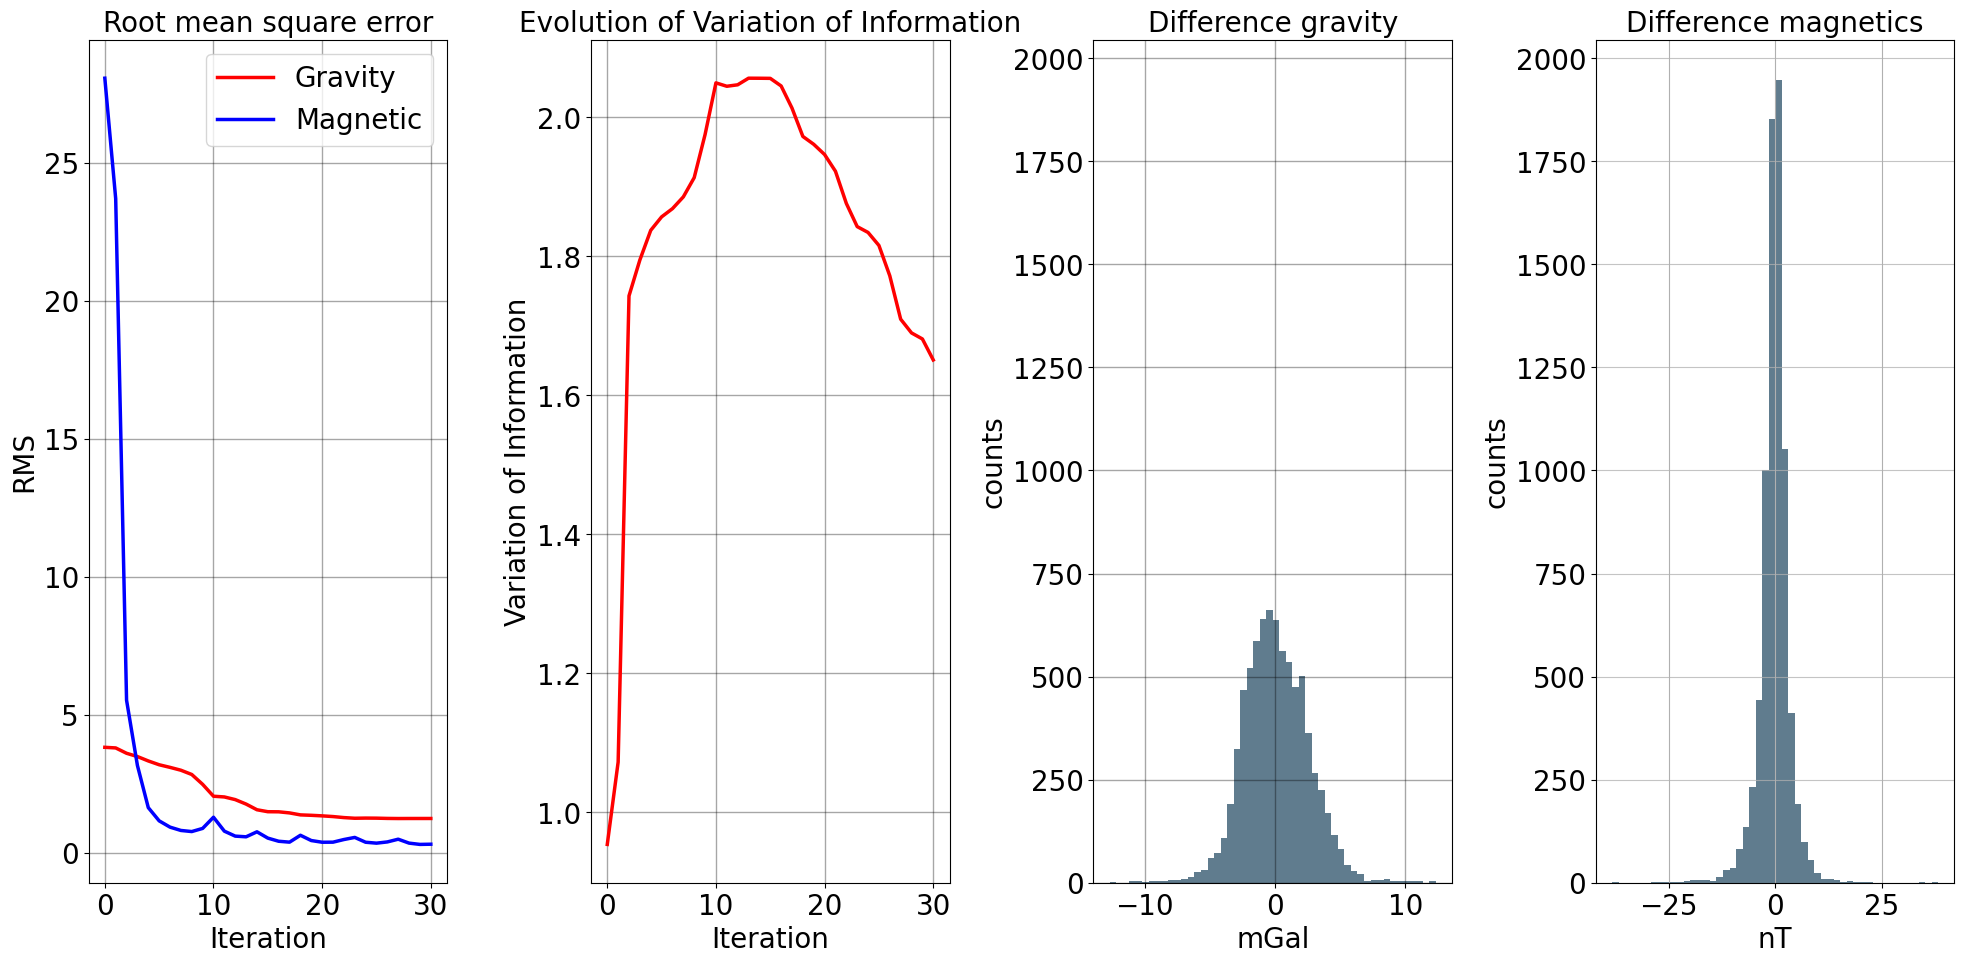

In [7]:
# load missift and rms data 


run1_misfit = np.genfromtxt(inv_run+'VI_inversion/misfit.out')
run1_rms = np.genfromtxt(inv_run+'VI_inversion/rms.out')

rms = run1_rms
misfit = run1_misfit


figure1, axs = plt.subplots(1, 4, figsize=(20,10),facecolor='white')

axs[0].plot(rms[:,1] , '-r' , linewidth=2.5 , label='Gravity')
axs[0].plot(rms[:,2] , '-b' , linewidth=2.5 , label='Magnetic')
axs[0].legend(loc='upper right' , prop={'size': 20})
axs[0].set_title("Root mean square error" , fontsize=20)
axs[0].set_xlabel('RMS', fontsize=20)
axs[0].grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
axs[0].set_xlabel('Iteration' , fontsize=20)
axs[0].set_ylabel('RMS' , fontsize=20)
axs[0].tick_params(axis="x", labelsize=20) 
axs[0].tick_params(axis="y", labelsize=20) 

axs[1].plot(misfit[:,4] , '-r' , linewidth=2.5)
axs[1].set_title('Evolution of Variation of Information' , fontsize=20)
axs[1].set_xlabel('Iteration', fontsize=20)
axs[1].set_ylabel('Variation of Information', fontsize=20)
# axs[2].sharey(axs[1])
axs[1].grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
axs[1].tick_params(axis="x", labelsize=20) 
axs[1].tick_params(axis="y", labelsize=20) 



diff_grav_pd.diff_grav.plot.hist(grid=True, bins=50 , ax=axs[2] ,  color='#607c8e')
axs[2].set_title('Difference gravity', fontsize=20)
axs[2].set_xlabel('mGal', fontsize=20)
axs[2].set_ylabel('counts', fontsize=20)
axs[2].grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
axs[2].tick_params(axis="x", labelsize=20) 
axs[2].tick_params(axis="y", labelsize=20) 



diff_mag_pd.diff_mag.plot.hist(grid=True, bins=50 , ax=axs[3] ,  color='#607c8e')
axs[3].set_title('Difference magnetics' , fontsize=20)
axs[3].set_xlabel('nT', fontsize=20)
axs[3].set_ylabel('counts', fontsize=20)

axs[3].grid(axis='y', alpha=0.75)
axs[3].tick_params(axis="x", labelsize=20) 
axs[3].tick_params(axis="y", labelsize=20) 

axs[2].sharey(axs[3])

figure1.tight_layout(pad=2)

plt.savefig(export_fig_path + 'inversion_stats.png',facecolor=figure1.get_facecolor(), transparent=True)



print("max grav error :", '{0:.1f}'.format(np.max(diff_grav)) , "mGal")
print("min grav error :", '{0:.1f}'.format(np.min(diff_grav)) , "mGal"),
print("mean grav error :", '{0:.1f}'.format(np.mean(diff_grav)) , "mGal")
print("std grav error :", '{0:.1f}'.format(np.std(diff_grav)) , "mGal \n")

print("max mag error :", '{0:.1f}'.format(np.max(diff_mag)) , "nT")
print("min mag error :", '{0:.1f}'.format(np.min(diff_mag)) , "nT"),
print("mean mag error :", '{0:.1f}'.format(np.mean(diff_mag)) , "nT")
print("std mag error :", '{0:.1f}'.format(np.std(diff_mag)) , "nT \n")



In [8]:
#read in magnetic inversion model
mag_fh = Dataset(inv_run+"VI_inversion/result.mag.inv.nc")
X_sus = mag_fh.variables["Northing"][:]
Y_sus =mag_fh.variables["Easting"][:] 
Depth_sus =mag_fh.variables["Depth"][:]
X_sus_Origin =mag_fh.variables["Northing_Origin"][:] 
Y_sus_Origin =mag_fh.variables["Easting_Origin"][:] 
Depth_sus_Origin =mag_fh.variables["Depth_Origin"][:]
inv_sus = mag_fh.variables["Susceptibility"][:,:,:]
mag_fh.close()

#and the corresponding gravity model, do not need geometry as we know it is the same
grav_fh = Dataset(inv_run+"VI_inversion/result.grav.inv.nc")
inv_dens = grav_fh.variables["Density"][:,:,:]
grav_fh.close()

In [9]:
xq , yq = np.meshgrid(X_sus , Y_sus)
Depth_inversion_km = np.round((Depth_sus/1000),1)

In [10]:
line_x = (min(xq[0,:])  , max(xq[0,:]))
line_y = (yq[74,0] , yq[74,0])
line_y

(1738750.0, 1738750.0)

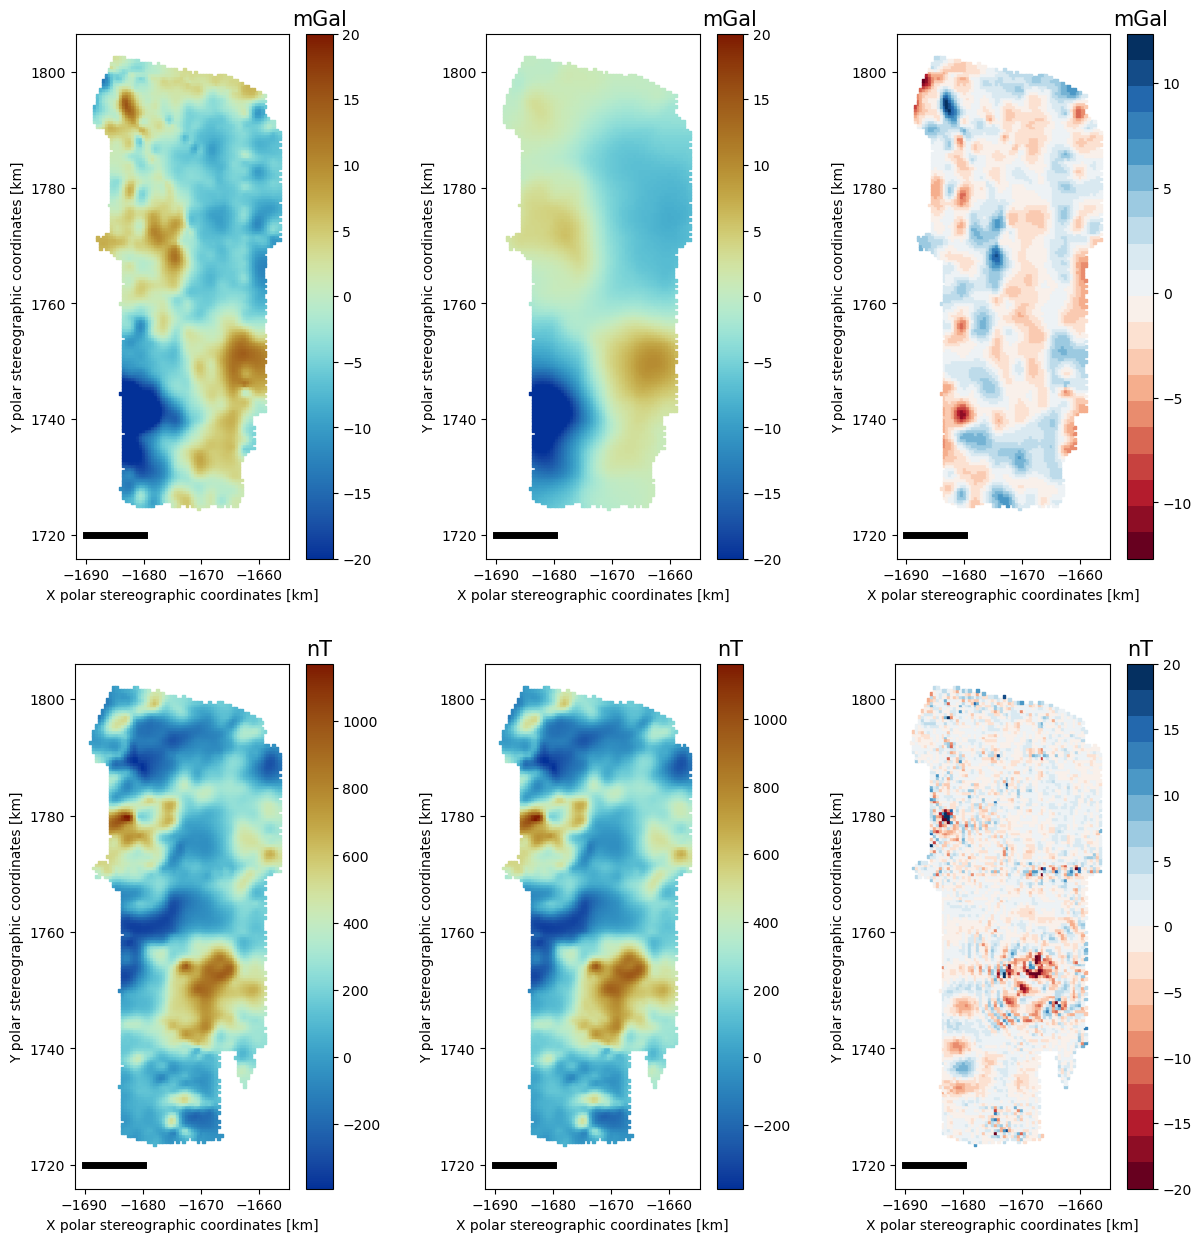

In [11]:
m=15 #fontsize
cmap = cm.roma_r
cmap_rev = cm.roma_r
cmap_grav_diff = plt.get_cmap('RdBu',20)


line_x = (0.25e6 , 1.6e6)
line_y = (-1741429 , -1741429)


figure1 = plt.figure(figsize=(15,15),facecolor='white')
# fig.tight_layout()


ax1 = plt.subplot(2, 3, 1)
# Coastline.plot(ax=ax1 , color = 'k' , linewidth = 0.5)
im = plt.scatter(X_input_grav/1000 , Y_input_grav/1000 , c=val_input_grav , marker='s', s=4, cmap = cmap_rev, vmin = -20 , vmax = 20)
axes=plt.gca()
axes = plt.gca()
cb1 = plt.colorbar(im , orientation='vertical' , shrink=1 , pad=0.05)
cb1.ax.set_title("mGal",fontsize=15)
ax1.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax1.plot([-1690000/1000, -1690000/1000 + 10000/1000], [1720000/1000, 1720000/1000], "-k", linewidth=5)  # 10 km scale bar

# ax1.plot(x_study_area/1000, y_study_area/1000, "r", linewidth=2, label="study area")



ax2 = plt.subplot(2, 3, 2)
im2 = plt.scatter(X_syn_grav/1000 , Y_syn_grav/1000 , c=val_syn_grav, marker='s', s=4, cmap =cmap_rev, vmin = -20 , vmax = 20 )
# Coastline.plot(ax=ax2 , color = 'k' , linewidth = 0.5)
axes=plt.gca()
cb2 = plt.colorbar(im2 , orientation='vertical' , shrink=1 , pad=0.05)
cb2.ax.set_title("mGal",fontsize=15)
# ax2.plot([1.2e6,1.2e6+300000],[-2.2e6,-2.2e6],'-k', linewidth=5) # 300 km scale bar
ax2.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax2.plot([-1690000/1000, -1690000/1000 + 10000/1000], [1720000/1000, 1720000/1000], "-k", linewidth=5)  # 10 km scale bar


ax3 = plt.subplot(2, 3, 3 )
im3 = plt.scatter(X_input_grav/1000 , Y_input_grav/1000 , c=diff_grav , marker='s' , s=4 , cmap=cmap_grav_diff ) #, vmin=-mxn_d/10, vmax=mxn_d/10)
# Coastline.plot(ax=ax3 , color = 'k' , linewidth = 0.5)
axes=plt.gca()
cb3 = plt.colorbar(im3 , orientation='vertical' , shrink=1 , pad=0.05)
cb3.ax.set_title("mGal",fontsize=15)
# ax3.plot([1.2e6,1.2e6+300000],[-2.2e6,-2.2e6],'-k', linewidth=5) # 300 km scale bar
ax3.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax3.plot([-1690000/1000, -1690000/1000 + 10000/1000], [1720000/1000, 1720000/1000], "-k", linewidth=5)  # 10 km scale bar


ax4 = plt.subplot(2, 3, 4 )
im4 = plt.scatter(X_input_mag/1000 , Y_input_mag/1000 , c=val_input_mag , marker='s', s=4 , cmap =cmap)
# Coastline.plot(ax=ax4 , color = 'k' , linewidth = 0.5)
axes=plt.gca()
cb4 = plt.colorbar(im4 , orientation='vertical' , shrink=1 , pad=0.05)
cb4.ax.set_title("nT",fontsize=15)
# ax4.plot([1.2e6,1.2e6+300000],[-2.2e6,-2.2e6],'-k', linewidth=5) # 300 km scale bar
ax4.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax4.plot([-1690000/1000, -1690000/1000 + 10000/1000], [1720000/1000, 1720000/1000], "-k", linewidth=5)  # 10 km scale bar


ax5 = plt.subplot(2, 3, 5 )
im5 = plt.scatter(X_syn_mag/1000 , Y_syn_mag/1000 , c=val_syn_mag , marker='s', s=4 , cmap =cmap )
# Coastline.plot(ax=ax5 , color = 'k' , linewidth = 0.5)
axes=plt.gca()
cb5 = plt.colorbar(im5 , orientation='vertical' , shrink=1 , pad=0.05)
cb5.ax.set_title("nT",fontsize=15)
# ax5.plot([1.2e6,1.2e6+300000],[-2.2e6,-2.2e6],'-k', linewidth=5) # 300 km scale bar
ax5.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax5.plot([-1690000/1000, -1690000/1000 + 10000/1000], [1720000/1000, 1720000/1000], "-k", linewidth=5)  # 10 km scale bar


ax6 = plt.subplot(2, 3, 6 )
cmap= plt.get_cmap('RdBu',20)
im6 = plt.scatter(X_input_mag/1000 , Y_input_mag/1000 , c=diff_mag , marker='s', s=4 , cmap=cmap_grav_diff  , vmin=-20, vmax = 20)
# Coastline.plot(ax=ax6 , color = 'k' , linewidth = 0.5)
axes=plt.gca()
cb6 = plt.colorbar(im6 , orientation='vertical' , shrink=1 , pad=0.05)
cb6.ax.set_title("nT",fontsize=15)
# ax6.plot([1.2e6,1.2e6+300000],[-2.2e6,-2.2e6],'-k', linewidth=5) # 300 km scale bar
ax6.set_aspect(1)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=10)
plt.ylabel("Y polar stereographic coordinates [km]", fontsize=10)
ax6.plot([-1690000/1000, -1690000/1000 + 10000/1000], [1720000/1000, 1720000/1000], "-k", linewidth=5)  # 10 km scale bar


# plt.savefig(inv_run+'Output/Figure/VI_inversion_maps_with_profil_location.png',facecolor=figure1.get_facecolor(), transparent=True)
plt.savefig('VI_inversion_maps_with_profil_location.png',facecolor=figure1.get_facecolor(), transparent=True)


In [12]:
#read in magnetic inversion model
mag_fh = Dataset(inv_run+"VI_inversion/result.mag.inv.nc")
X_sus = mag_fh.variables["Northing"][:] 
Y_sus =mag_fh.variables["Easting"][:] 
Depth_sus =mag_fh.variables["Depth"][:]
X_sus_Origin =mag_fh.variables["Northing_Origin"][:] 
Y_sus_Origin =mag_fh.variables["Easting_Origin"][:] 
Depth_sus_Origin =mag_fh.variables["Depth_Origin"][:]
inv_sus = mag_fh.variables["Susceptibility"][:,:,:]
mag_fh.close()

#and the corresponding gravity model, do not need geometry as we know it is the same
grav_fh = Dataset(inv_run+"VI_inversion/result.grav.inv.nc")
inv_dens = grav_fh.variables["Density"][:,:,:]
grav_fh.close()

In [15]:
xq , yq = np.meshgrid(X_sus , Y_sus)
Depth_inversion_km = np.round((Depth_sus/1000),1)

In [16]:
topointer = griddata(
    (Boundaries_SWARM.x_ps, Boundaries_SWARM.y_ps),
    Boundaries_SWARM.bedrock,
    (xq, yq),
    method="linear",
)

# Mohointer = griddata(
#     (Boundaries_SWARM.x_ps, Boundaries_SWARM.y_ps),
#     Boundaries_SWARM.Moho,
#     (xq, yq),
#     method="linear",
# )

# CPDinter = griddata(
#     (Boundaries_SWARM.x_ps, Boundaries_SWARM.y_ps),
#     Boundaries_SWARM.CPD,
#     (xq, yq),
#     method="linear",
# )

x_profil, z_profil = np.meshgrid(X_sus, Depth_sus)


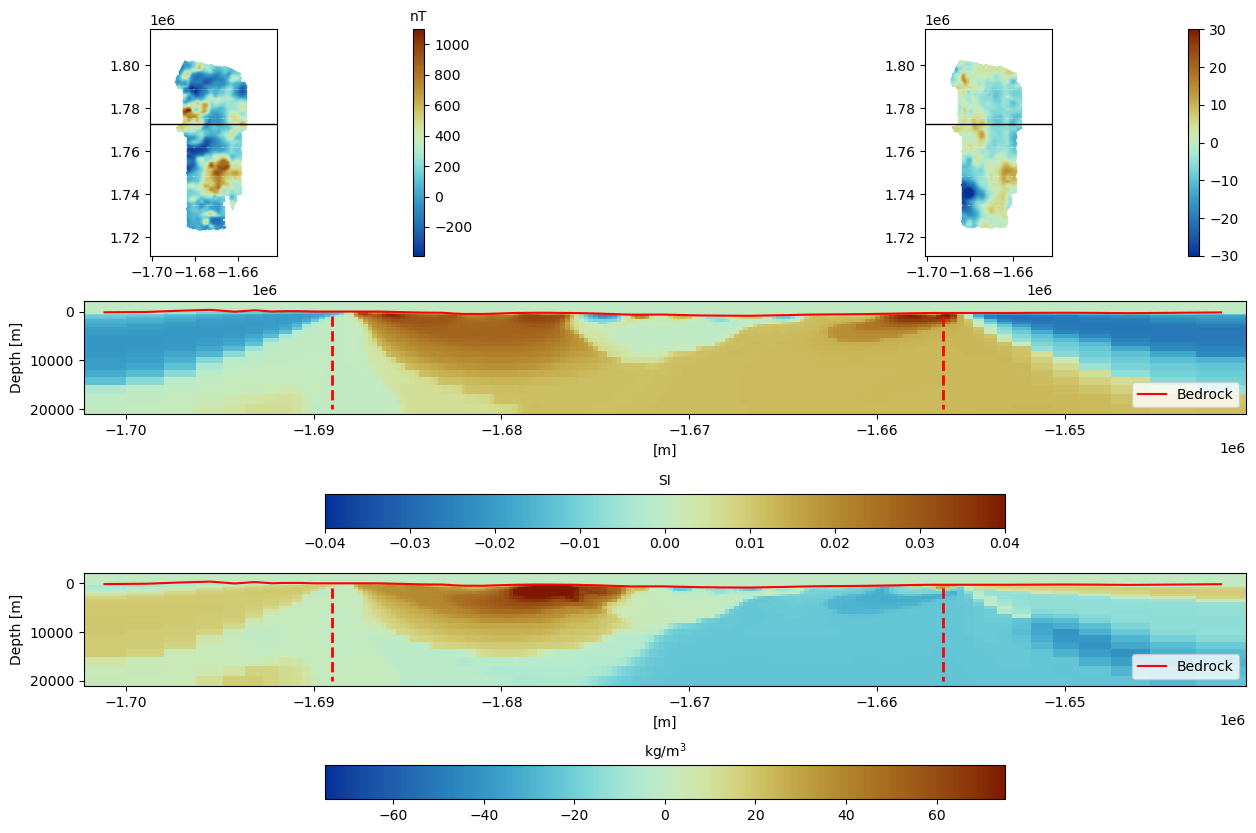

In [17]:
# create output folder

# export_profiles_gif_vertical_ordered = (
#     inv_run + "Output/Figure/Fig2_inverted_sus_cross_section/"
# )

# # Create path if it does not exists
# if not os.path.exists(export_profiles_gif_vertical_ordered):
#     os.makedirs(export_profiles_gif_vertical_ordered)

# define fontsize
fontsize_index = 10


j = 209

sus_profil_ix = inv_sus[:, j, :]
line_x = (min(x_profil[0, :]), max(x_profil[0, :]))
line_y = (yq[j, 0], yq[j, 0])
dens_profil_ix = inv_dens[:, j, :]



## plot profile location
figure1 = plt.figure(figsize=(15, 10), facecolor="white")
spec = figure1.add_gridspec(3, 2, hspace=0.2, wspace=1)
ax0 = figure1.add_subplot(spec[0, 0])

im1 = plt.scatter(X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=0.5, cmap=cmap_rev, vmax=1100)

# Coastline.plot(ax=ax0 , color = 'k' , linewidth = 0.5)
axes = plt.gca()
cb1 = plt.colorbar(im1, shrink=1, orientation="vertical", pad=0.35)
cb1.ax.set_title("nT", fontsize=fontsize_index)
ax0.plot(line_x, line_y, color="k", linewidth=1)
plt.gca().set_aspect(1)
ax0.set_xlim(np.min(X_sus), np.max(X_sus))
ax0.set_ylim(np.min(Y_sus), np.max(Y_sus))

# plot sus profil
ax2 = figure1.add_subplot(spec[1, :])
im2 = plt.pcolormesh(
    x_profil, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.04, vmax=0.04
)
plt.xlabel("[m]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
# ax2.set_xlim([505000, 572000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.35)
cb.ax.set_title(unit_sus, fontsize=fontsize_index)
plt.plot(x_profil[0, :], topointer[j, :] * -1, c="red", label="Bedrock")
# plt.plot(x_profil[0,:],CPDinter[j,:]*1000 , c='c' , label='CPD')
# plt.plot(x_profil[0,:],Mohointer[j,:]*1000 , c='blue', label='Moho')
ax2.legend(loc="lower right", prop={"size": 10})
ax2.vlines(x=[np.min(x_study_area), np.max(x_study_area)], ymin=[1000, 1000], ymax=[20000, 20000], colors='red', ls='--', lw=2)

ax3 = figure1.add_subplot(spec[0, 1])

im3 = plt.scatter(
    X_input_grav, Y_input_grav, c=val_input_grav, marker="s", s=0.5, cmap=cmap_rev, vmin = -30 , vmax = 30
)
# Coastline.plot(ax=ax3 , color = 'k' , linewidth = 0.5)
axes = plt.gca()
cb3 = plt.colorbar(im3, shrink=1, orientation="vertical", pad=0.35)
# cb1.ax.set_title("mGal", fontsize=fontsize_index)
ax3.plot(line_x, line_y, color="k", linewidth=1)
plt.gca().set_aspect(1)
ax3.set_xlim(np.min(X_sus), np.max(X_sus))
ax3.set_ylim(np.min(Y_sus), np.max(Y_sus))

# plot sus profil
ax4 = figure1.add_subplot(spec[2, :])
im4 = plt.pcolormesh(
    x_profil, z_profil, dens_profil_ix, cmap=cmap_rev, vmin=-75, vmax=75,
)
plt.xlabel("[m]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# # ax2.set_ylim([-4000, 5000])
# # ax2.set_xlim([505000, 572000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im4, shrink=1, orientation="horizontal", pad=0.35)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(x_profil[0, :], topointer[j, :] * -1, c="red", label="Bedrock")
# plt.plot(x_profil[0,:],CPDinter[j,:]*1000 , c='c' , label='CPD')
# plt.plot(x_profil[0,:],Mohointer[j,:]*1000 , c='blue', label='Moho')
ax4.legend(loc="lower right", prop={"size": 10})
ax4.vlines(x=[np.min(x_study_area), np.max(x_study_area)], ymin=[1000, 1000], ymax=[20000, 20000], colors='red', ls='--', lw=2)
# plt.savefig('inversion_profile_overview.png',facecolor=figure1.get_facecolor(), transparent=True)


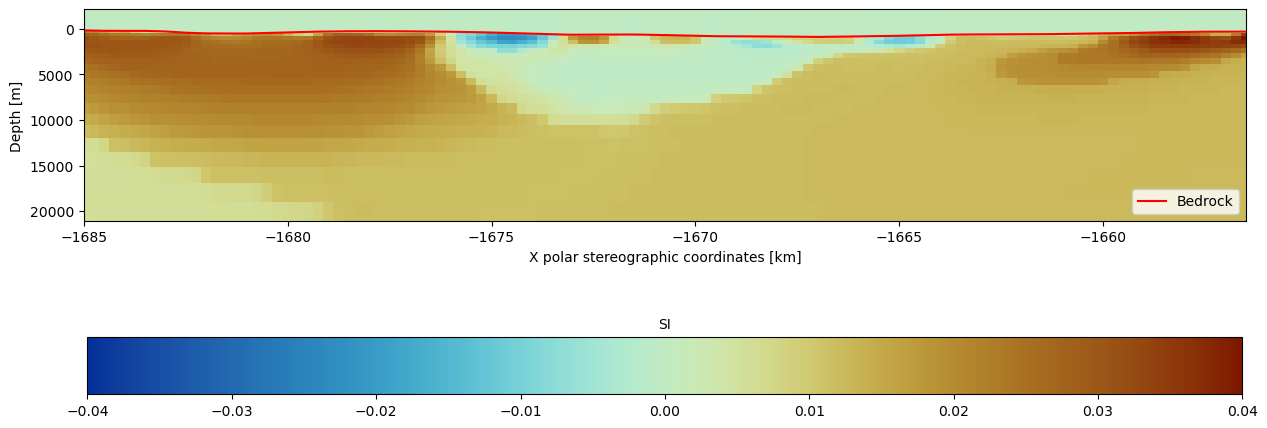

In [18]:

# define fontsize
fontsize_index = 10

j = 209

sus_profil_ix = inv_sus[:, j, :]
line_x = (min(x_profil[0, :]), max(x_profil[0, :]))
line_y = (yq[j, 0], yq[j, 0])
dens_profil_ix = inv_dens[:, j, :]

## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)

# plot sus profil
im2 = ax2.pcolormesh(
    x_profil/1000, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.04, vmax=0.04
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
ax2.set_xlim([-1685000/1000, -1656500/1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_sus, fontsize=fontsize_index)
plt.plot(x_profil[0, :]/1000, topointer[j, :] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
# plt.savefig('inversion_profile_vertical_209_sus_full_model.png',facecolor=figure1.get_facecolor(), transparent=True)




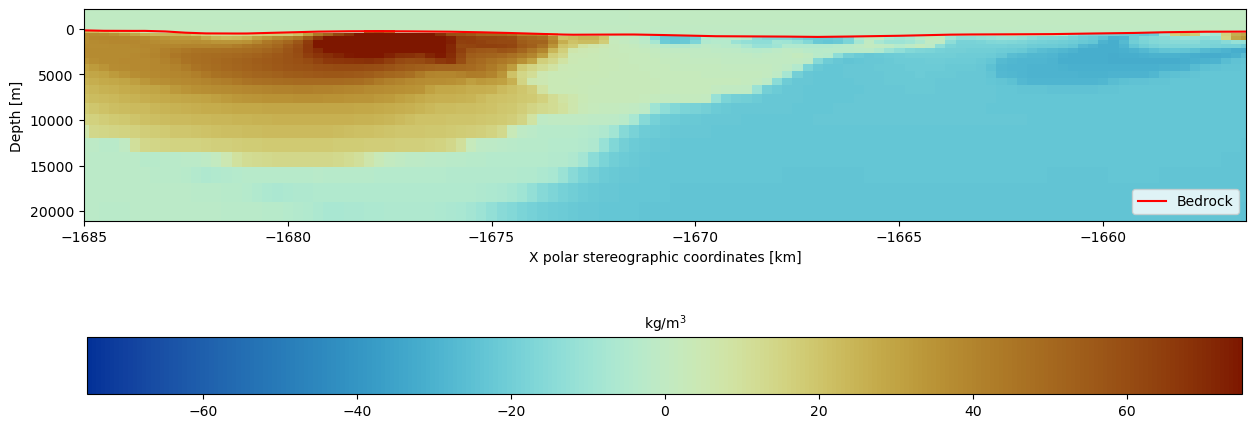

In [19]:

# define fontsize
fontsize_index = 10


j = 209

sus_profil_ix = inv_sus[:, j, :]
line_x = (min(x_profil[0, :]), max(x_profil[0, :]))
line_y = (yq[j, 0], yq[j, 0])
dens_profil_ix = inv_dens[:, j, :]




## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)


# plot sus profil
im2 = plt.pcolormesh(
    x_profil/1000, z_profil, dens_profil_ix, cmap=cmap_rev, vmin=-75, vmax=75
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
ax2.set_xlim([-1685000/1000, -1656500/1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(x_profil[0, :]/1000, topointer[j, :] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
# plt.savefig('inversion_profile_vertical_209_dens_full_model.png',facecolor=figure1.get_facecolor(), transparent=True)



In [20]:
Mag_obs_merged =  np.vstack((X_input_mag ,Y_input_mag , val_input_mag)).T
Mag_obs_merged

masked_array(
  data=[[-1.67800000e+06,  1.72350000e+06,  8.83361053e+01],
        [-1.67900000e+06,  1.72400000e+06,  6.03579140e+01],
        [-1.67850000e+06,  1.72400000e+06,  6.93464584e+01],
        ...,
        [-1.68450000e+06,  1.80200000e+06,  5.25720739e+00],
        [-1.68150000e+06,  1.80200000e+06,  1.31489471e+02],
        [-1.68100000e+06,  1.80200000e+06,  1.58240387e+02]],
  mask=False,
  fill_value=1e+20)

In [21]:
Mag_syn_merged =  np.vstack((X_syn_mag ,Y_syn_mag , val_syn_mag)).T
Mag_syn_merged

masked_array(
  data=[[-1.67800000e+06,  1.72350000e+06,  7.82980332e+01],
        [-1.67900000e+06,  1.72400000e+06,  5.57427759e+01],
        [-1.67850000e+06,  1.72400000e+06,  6.91075855e+01],
        ...,
        [-1.68450000e+06,  1.80200000e+06,  3.12412109e+00],
        [-1.68150000e+06,  1.80200000e+06,  1.27493306e+02],
        [-1.68100000e+06,  1.80200000e+06,  1.52235011e+02]],
  mask=False,
  fill_value=1e+20)

In [22]:
Grav_obs_merged =  np.vstack((X_input_grav ,Y_input_grav , val_input_grav)).T
Grav_obs_merged

masked_array(
  data=[[-1.67050000e+06,  1.72450000e+06,  1.93605638e+00],
        [-1.68100000e+06,  1.72500000e+06, -5.64796495e+00],
        [-1.68050000e+06,  1.72500000e+06, -5.63538456e+00],
        ...,
        [-1.68450000e+06,  1.80250000e+06,  2.52197671e+00],
        [-1.68400000e+06,  1.80250000e+06,  1.98615694e+00],
        [-1.68350000e+06,  1.80250000e+06,  1.17806113e+00]],
  mask=False,
  fill_value=1e+20)

In [23]:
Grav_syn_merged =  np.vstack((X_syn_grav ,Y_syn_grav , val_syn_grav)).T
Grav_syn_merged

masked_array(
  data=[[-1.67050000e+06,  1.72450000e+06, -1.07081380e+00],
        [-1.68100000e+06,  1.72500000e+06, -6.61303886e+00],
        [-1.68050000e+06,  1.72500000e+06, -6.38961570e+00],
        ...,
        [-1.68450000e+06,  1.80250000e+06,  2.67911491e-02],
        [-1.68400000e+06,  1.80250000e+06, -2.22866174e-02],
        [-1.68350000e+06,  1.80250000e+06, -7.70190249e-02]],
  mask=False,
  fill_value=1e+20)

In [24]:
obs_mag_horizontal_profile_ix = []
for i in range(len(Mag_obs_merged[:,0])):
    if Mag_obs_merged[i,1] == 1772500:
        obs_mag_horizontal_profile_ix.append(Mag_obs_merged[i,:])
obs_mag_horizontal_profile = np.array(obs_mag_horizontal_profile_ix)

In [25]:
syn_mag_horizontal_profile_ix = []
for i in range(len(Mag_syn_merged[:,0])):
    if Mag_syn_merged[i,1] == 1772500:
        syn_mag_horizontal_profile_ix.append(Mag_syn_merged[i,:])
syn_mag_horizontal_profile = np.array(syn_mag_horizontal_profile_ix)

In [26]:
obs_grav_horizontal_profile_ix = []
for i in range(len(Grav_obs_merged[:,0])):
    if Grav_obs_merged[i,1] == 1772500:
        obs_grav_horizontal_profile_ix.append(Grav_obs_merged[i,:])
obs_grav_horizontal_profile = np.array(obs_grav_horizontal_profile_ix)

In [27]:
syn_grav_horizontal_profile_ix = []
for i in range(len(Grav_syn_merged[:,0])):
    if Grav_syn_merged[i,1] == 1772500:
        syn_grav_horizontal_profile_ix.append(Grav_syn_merged[i,:])
syn_grav_horizontal_profile = np.array(syn_grav_horizontal_profile_ix)

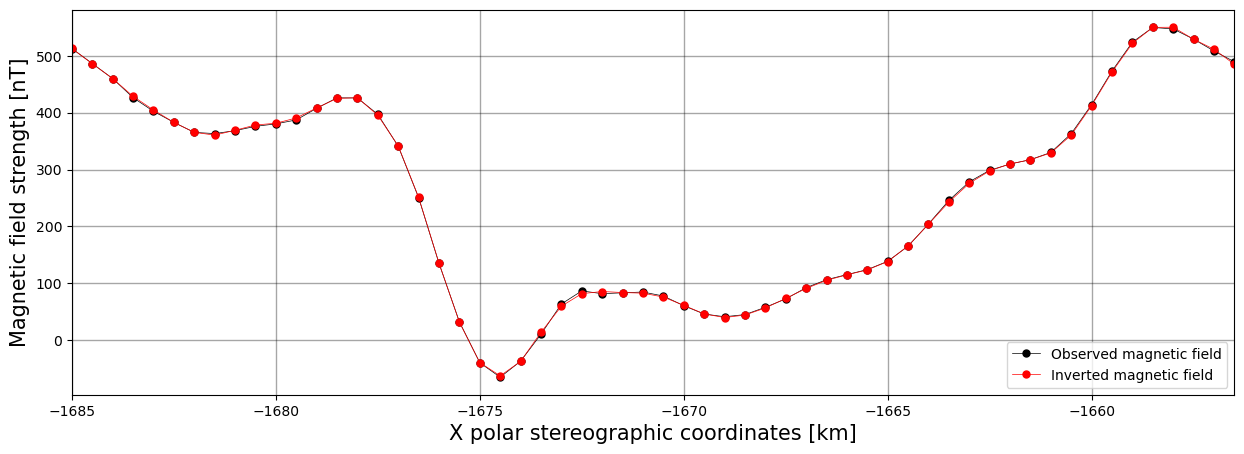

In [28]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(obs_mag_horizontal_profile[:,0]/1000, obs_mag_horizontal_profile[:, 2] , 'o-k', linewidth=0.5, markersize=5, label='Observed magnetic field')
plt.plot(syn_mag_horizontal_profile[:,0]/1000, syn_mag_horizontal_profile[:, 2] , 'o-r', linewidth=0.5, markersize=5, label='Inverted magnetic field')
ax2.set_xlim([-1685000/1000, -1656500/1000])
# ax2.set_ylim([25, 100])
ax2.legend(loc='lower right' , prop={'size': 10})
ax2.set_ylabel('Magnetic field strength [nT]' , fontsize=15)
ax2.set_xlabel('X polar stereographic coordinates [km]' , fontsize=15)
ax2.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
# plt.savefig('mag_obs_syn_horizontal_profile_plot.png',facecolor=figure1.get_facecolor(), transparent=True)


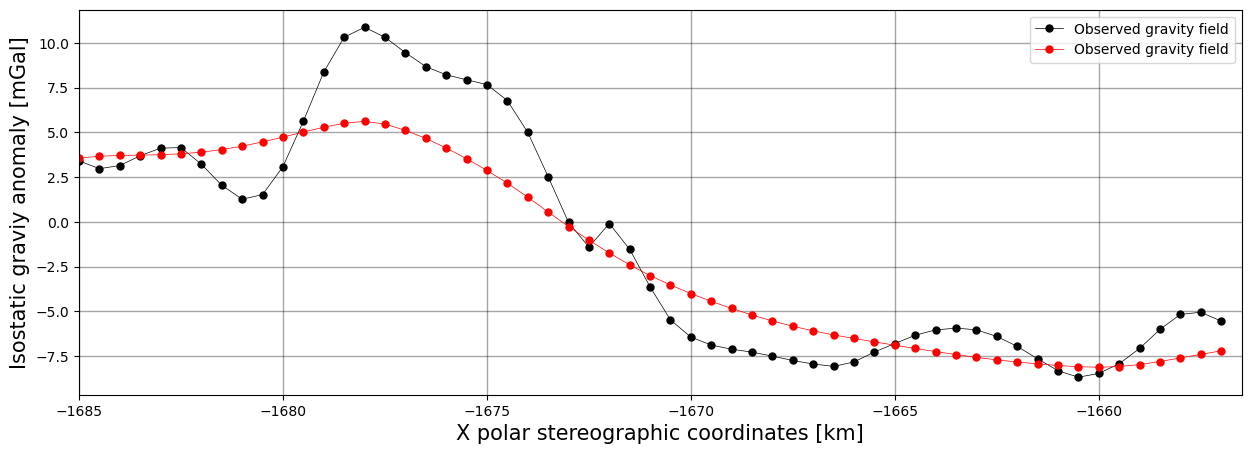

In [29]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(obs_grav_horizontal_profile[:,0]/1000, obs_grav_horizontal_profile[:, 2] , 'o-k', linewidth=0.5, markersize=5, label='Observed gravity field')
plt.plot(syn_grav_horizontal_profile[:,0]/1000, syn_grav_horizontal_profile[:, 2] , 'o-r', linewidth=0.5, markersize=5, label='Observed gravity field')
ax2.set_xlim([-1685000/1000, -1656500/1000])
# ax2.set_ylim([25, 100])
ax2.legend(loc='upper right' , prop={'size': 10})
ax2.set_ylabel('Isostatic graviy anomaly [mGal]' , fontsize=15)
ax2.set_xlabel('X polar stereographic coordinates [km]' , fontsize=15)
ax2.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
# plt.savefig('grav_obs_syn_horizontal_profile_plot.png',facecolor=figure1.get_facecolor(), transparent=True)


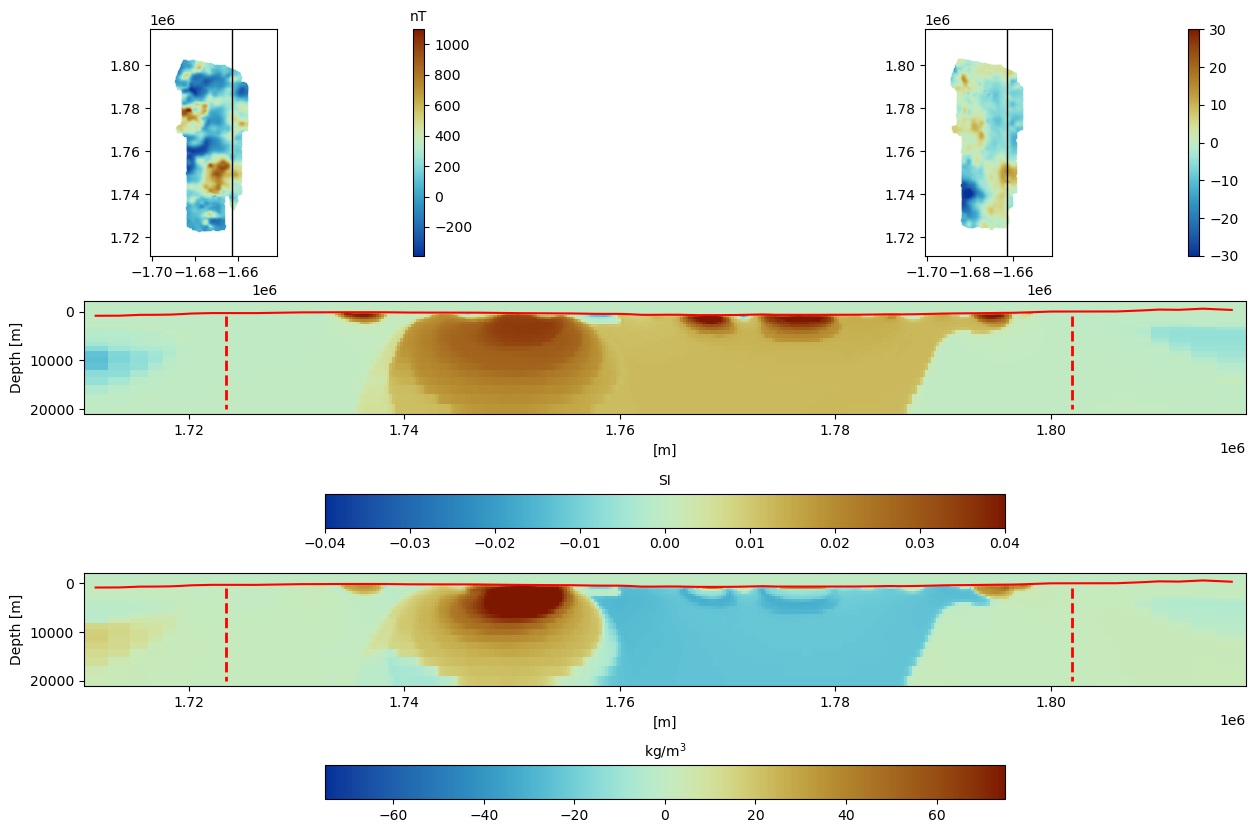

In [31]:
y_profil, z_profil = np.meshgrid(Y_sus, Depth_sus)

j = 117


# create output folder
export_profiles_gif_vertical_ordered = (
    inv_run + "Output/Figure/Fig4_inverted_sus_cross_section_long/"
)

# Create path if it does not exists
if not os.path.exists(export_profiles_gif_vertical_ordered):
    os.makedirs(export_profiles_gif_vertical_ordered)

# define fontsize
fontsize_index = 10


sus_profil_ix = inv_sus[:, :, j]
line_x = (xq[0, j] , xq[0, j])
line_y = (min(y_profil[0,:]), max(y_profil[0, :]))

dens_profil_ix = inv_dens[:, :, j]


## plot profile location
figure1 = plt.figure(figsize=(15, 10), facecolor="white")
spec = figure1.add_gridspec(3, 2, hspace=0.2, wspace=1)
ax0 = figure1.add_subplot(spec[0, 0])

im1 = plt.scatter(
    X_syn_mag, Y_syn_mag, c=val_syn_mag, marker="s", s=2, cmap=cmap_rev, vmax=1100
)
# Coastline.plot(ax=ax0 , color = 'k' , linewidth = 0.5)
axes = plt.gca()
cb1 = plt.colorbar(im1, shrink=1, orientation="vertical", pad=0.35)
cb1.ax.set_title("nT", fontsize=fontsize_index)
ax0.plot(line_x, line_y, color="k", linewidth=1)
plt.gca().set_aspect(1)
ax0.set_xlim(np.min(X_sus), np.max(X_sus))
ax0.set_ylim(np.min(Y_sus), np.max(Y_sus))

# plot sus profil
ax2 = figure1.add_subplot(spec[1, :])
im2 = plt.pcolormesh(
    y_profil, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.04, vmax=0.04
)
plt.xlabel("[m]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
# ax2.set_xlim([505000, 572000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.35)
cb.ax.set_title(unit_sus, fontsize=fontsize_index)
plt.plot(y_profil[0, :], topointer[:, j] * -1, c="red", label="Bedrock")
# plt.plot(x_profil[0,:],CPDinter[j,:]*1000 , c='c' , label='CPD')
# plt.plot(x_profil[0,:],Mohointer[j,:]*1000 , c='blue', label='Moho')
# ax2.legend(loc="lower right", prop={"size": 10})
ax2.vlines(x=[np.min(y_study_area), np.max(y_study_area)], ymin=[1000, 1000], ymax=[20000, 20000], colors='red', ls='--', lw=2)



ax3 = figure1.add_subplot(spec[0, 1])

im3 = plt.scatter(
    X_input_grav, Y_input_grav, c=val_input_grav, marker="s", s=2, cmap=cmap_rev, vmin = -30 , vmax = 30
)
# Coastline.plot(ax=ax3 , color = 'k' , linewidth = 0.5)
axes = plt.gca()
cb3 = plt.colorbar(im3, shrink=1, orientation="vertical", pad=0.35)
# cb1.ax.set_title("mGal", fontsize=fontsize_index)
ax3.plot(line_x, line_y, color="k", linewidth=1)
plt.gca().set_aspect(1)
ax3.set_xlim(np.min(X_sus), np.max(X_sus))
ax3.set_ylim(np.min(Y_sus), np.max(Y_sus))

# plot sus profil
ax4 = figure1.add_subplot(spec[2, :])
im4 = plt.pcolormesh(
    y_profil, z_profil, dens_profil_ix, cmap=cmap_rev, vmin=-75, vmax=75,
)
plt.xlabel("[m]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# # ax2.set_ylim([-4000, 5000])
# # ax2.set_xlim([505000, 572000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im4, shrink=1, orientation="horizontal", pad=0.35)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(y_profil[0, :], topointer[:, j] * -1, c="red", label="Bedrock")
# plt.plot(x_profil[0,:],CPDinter[j,:]*1000 , c='c' , label='CPD')
# plt.plot(x_profil[0,:],Mohointer[j,:]*1000 , c='blue', label='Moho')
# ax4.legend(loc="lower right", prop={"size": 10})
ax4.vlines(x=[np.min(y_study_area), np.max(y_study_area)], ymin=[1000, 1000], ymax=[20000, 20000], colors='red', ls='--', lw=2)





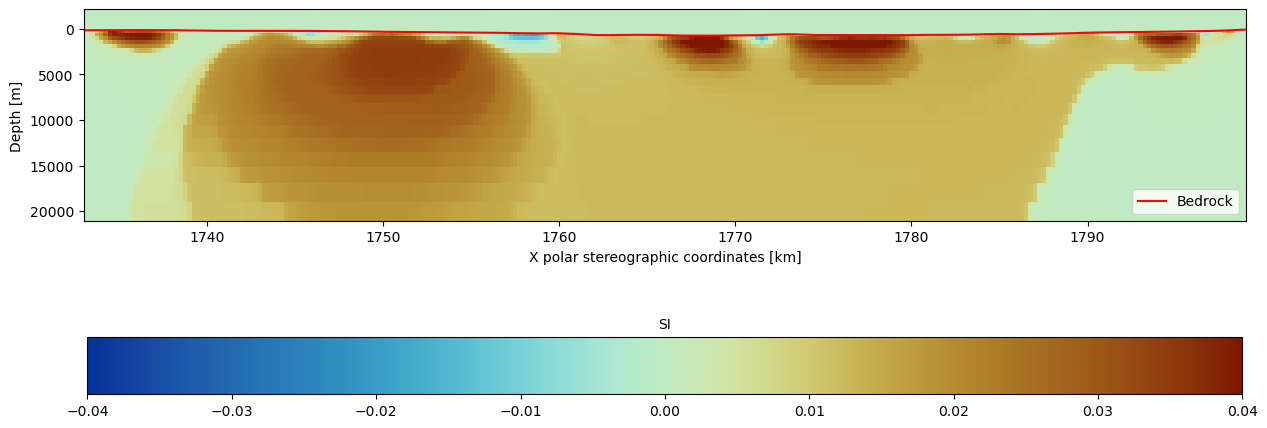

In [32]:
## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)

# plot sus profil
im2 = ax2.pcolormesh(
    y_profil/1000, z_profil, sus_profil_ix, cmap=cmap_rev, vmin=-0.04, vmax=0.04
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
ax2.set_xlim([1733000/1000, 1799000/1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_sus, fontsize=fontsize_index)
plt.plot(y_profil[0, :]/1000, topointer[:, j] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
# plt.savefig('inversion_profile_horizontal_117_sus_full_model.png',facecolor=figure1.get_facecolor(), transparent=True)

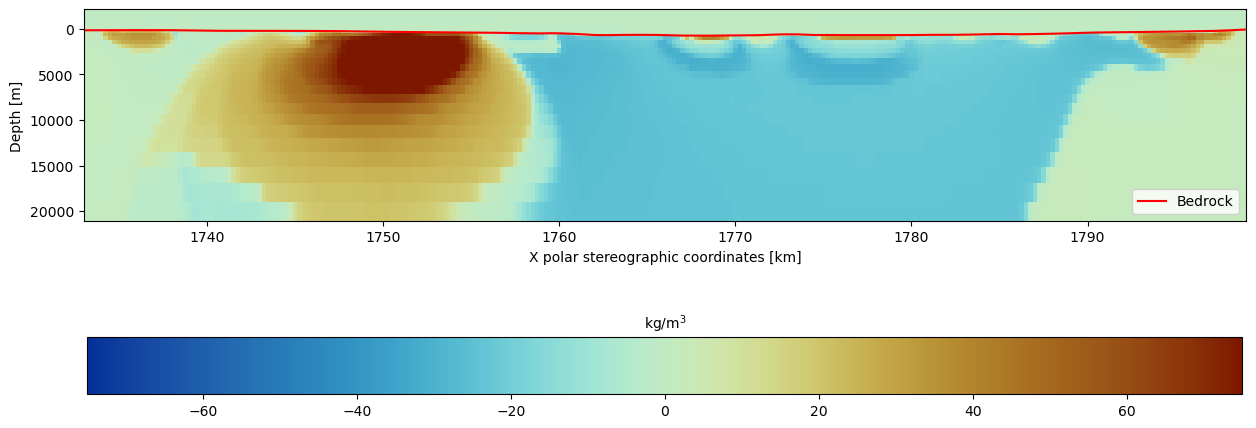

In [34]:
## plot profile location
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)

# plot sus profil
im2 = ax2.pcolormesh(
    y_profil/1000, z_profil, dens_profil_ix, cmap=cmap_rev, vmin=-75, vmax=75
)
plt.xlabel("X polar stereographic coordinates [km]", fontsize=fontsize_index)
plt.ylabel("Depth [m]", fontsize=fontsize_index)
# ax2.set_ylim([-4000, 5000])
ax2.set_xlim([1733000/1000, 1799000/1000])
ax = plt.gca()
ax.invert_yaxis()
cb = plt.colorbar(im2, shrink=1, orientation="horizontal", pad=0.30)
cb.ax.set_title(unit_dens, fontsize=fontsize_index)
plt.plot(y_profil[0, :]/1000, topointer[:, j] * -1, c="red", label="Bedrock")
ax2.legend(loc="lower right", prop={"size": 10})
# plt.savefig('inversion_profile_horizontal_117_dens_full_model.png',facecolor=figure1.get_facecolor(), transparent=True)

In [35]:
obs_mag_vertical_profile_ix = []
for i in range(len(Mag_obs_merged[:,0])):
    if Mag_obs_merged[i,0] == -1663000:
        obs_mag_vertical_profile_ix.append(Mag_obs_merged[i,:])
obs_mag_vertical_profile = np.array(obs_mag_vertical_profile_ix)

In [36]:
syn_mag_vertical_profile_ix = []
for i in range(len(Mag_syn_merged[:,1])):
    if Mag_syn_merged[i,0] == -1663000:
        syn_mag_vertical_profile_ix.append(Mag_syn_merged[i,:])
syn_mag_vertical_profile = np.array(syn_mag_vertical_profile_ix)

In [37]:
obs_grav_vertical_profile_ix = []
for i in range(len(Grav_obs_merged[:,1])):
    if Grav_obs_merged[i,0] == -1663000:
        obs_grav_vertical_profile_ix.append(Grav_obs_merged[i,:])
obs_grav_vertical_profile = np.array(obs_grav_vertical_profile_ix)

In [38]:
syn_grav_vertical_profile_ix = []
for i in range(len(Grav_syn_merged[:,1])):
    if Grav_syn_merged[i,0] == -1663000:
        syn_grav_vertical_profile_ix.append(Grav_syn_merged[i,:])
syn_grav_vertical_profile = np.array(syn_grav_vertical_profile_ix)

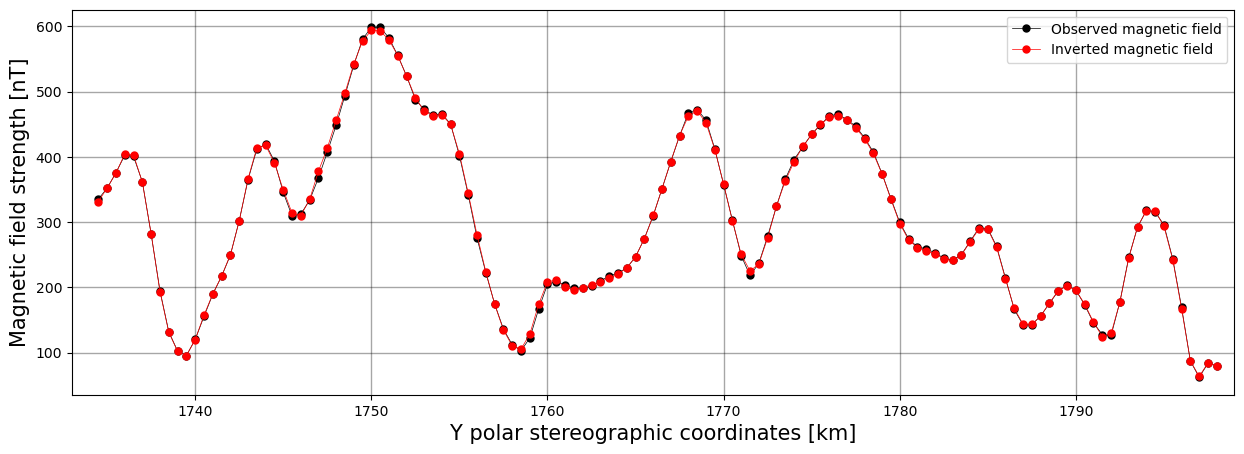

In [39]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(obs_mag_vertical_profile[:,1]/1000, obs_mag_vertical_profile[:, 2] , 'o-k', linewidth=0.5, markersize=5, label='Observed magnetic field')
plt.plot(syn_mag_vertical_profile[:,1]/1000, syn_mag_vertical_profile[:, 2] , 'o-r', linewidth=0.5, markersize=5, label='Inverted magnetic field')
ax2.set_xlim([1733000/1000, 1799000/1000])
# ax2.set_ylim([25, 100])
ax2.legend(loc='upper right' , prop={'size': 10})
ax2.set_ylabel('Magnetic field strength [nT]' , fontsize=15)
ax2.set_xlabel('Y polar stereographic coordinates [km]' , fontsize=15)
ax2.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
# plt.savefig('mag_obs_syn_vertical_profile_117_profile_plot.png',facecolor=figure1.get_facecolor(), transparent=True)


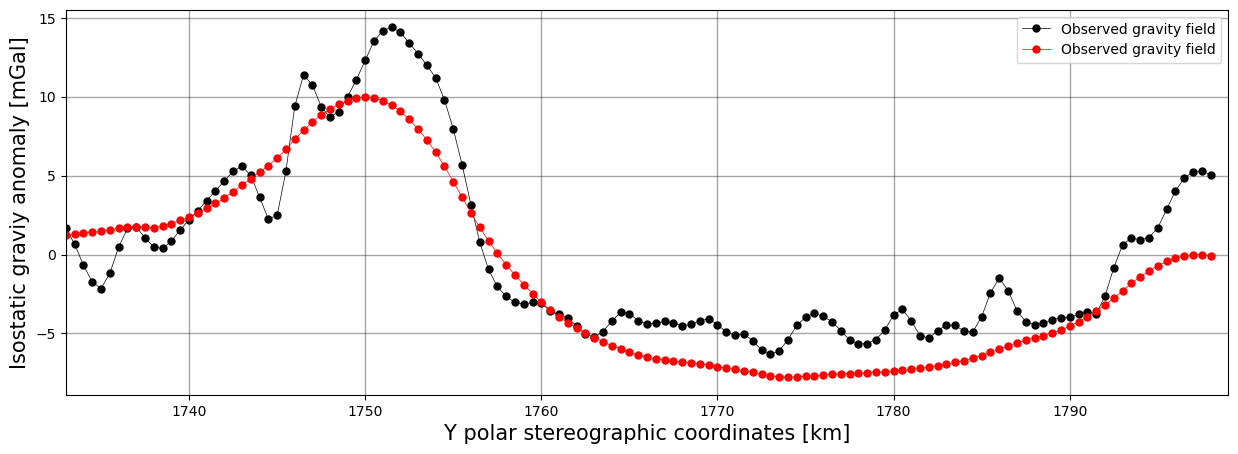

In [40]:
figure1 = plt.figure(figsize=(15, 5), facecolor="white")
ax2 = plt.subplot(1, 1, 1)
plt.plot(obs_grav_vertical_profile[:,1]/1000, obs_grav_vertical_profile[:, 2] , 'o-k', linewidth=0.5, markersize=5, label='Observed gravity field')
plt.plot(syn_grav_vertical_profile[:,1]/1000, syn_grav_vertical_profile[:, 2] , 'o-r', linewidth=0.5, markersize=5, label='Observed gravity field')
ax2.set_xlim([1733000/1000, 1799000/1000])
# ax2.set_ylim([25, 100])
ax2.legend(loc='upper right' , prop={'size': 10})
ax2.set_ylabel('Isostatic graviy anomaly [mGal]' , fontsize=15)
ax2.set_xlabel('Y polar stereographic coordinates [km]' , fontsize=15)
ax2.grid(color='k', linestyle='-', linewidth=1 , alpha=0.35 , which='major')
# plt.savefig('grav_obs_syn_vertical_profile_117_profile_plot.png',facecolor=figure1.get_facecolor(), transparent=True)
